In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


accedemos al dataset

In [2]:
zip_path = '/content/drive/MyDrive/ProyectoAlzheimer/Dataset/dataset.zip'
extract_path = '/content/dataset'

In [3]:
import zipfile
import os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


activar mixed precision

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

cargar dataset

In [5]:
base_dir = '/content/dataset'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

cargar hiperparámetros

In [6]:
input_shape = (128, 128, 3)
num_classes = 4
class_names = ['AD', 'CN', 'EMCI', 'LMCI']
batch_size = 32
epochs = 12

CNN1 con módulos residuales

In [7]:
from tensorflow.keras import layers, Input, Model

# 🔁 Bloque residual
def residual_block(x, filters, kernel_size=3, name_prefix="res"):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.Add(name=f"{name_prefix}_add")([x, shortcut])
    x = layers.Activation('relu', name=f"{name_prefix}_relu")(x)
    return x

# 🧠 Modelo con solo CNN1
def build_cnn1_residual_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # 🧩 CNN 1
    x1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x1 = residual_block(x1, 16, name_prefix="cnn1_res0")
    x1 = layers.MaxPooling2D((2, 2))(x1)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = residual_block(x1, 64, name_prefix="cnn1_res1")
    x1 = layers.MaxPooling2D((2, 2))(x1)

    x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
    x1 = residual_block(x1, 256, name_prefix="cnn1_res2")
    x1 = layers.MaxPooling2D((2, 2))(x1)

    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.5)(x1)
    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(128, activation='relu')(x1)

    output = layers.Dense(num_classes, activation='softmax')(x1)

    return Model(inputs=inputs, outputs=output)


Generadores de datos

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 23244 images belonging to 4 classes.
Found 5812 images belonging to 4 classes.
Found 7264 images belonging to 4 classes.


Entrenamiento del modelo

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. Definir modelo
model = build_cnn1_residual_model(input_shape, num_classes)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 2. Callback de detención temprana
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 3. Entrenamiento
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ cast[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_res0_add (Add) │ (None, 128, 128,  │          0 │ conv2d_2[0][0],   │
│                     │ 16)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_res0_relu      │ (None, 128, 128,  │          0 │ cnn1_res0_add[0]… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ cnn1_res0_relu[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,280 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_res1_add (Add) │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn1_res1_relu      │ (None, 64, 64,    │          0 │ cnn1_res1_add[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ cnn1_res1_relu[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    147,712 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_7[0][0]  

 Total params: 9,806,372 (37.41 MB)

 Trainable params: 9,805,860 (37.41 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


727/727 ━━━━━━━━━━━━━━━━━━━━ 71s 65ms/step - accuracy: 0.4843 - loss: 1.4011 - val_accuracy: 0.6874 - val_loss: 0.7372
Epoch 2/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.7555 - loss: 0.5772 - val_accuracy: 0.8047 - val_loss: 0.5070
Epoch 3/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.8391 - loss: 0.4055 - val_accuracy: 0.8429 - val_loss: 0.3897
Epoch 4/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.8954 - loss: 0.2761 - val_accuracy: 0.8909 - val_loss: 0.2832
Epoch 5/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.9304 - loss: 0.1887 - val_accuracy: 0.8405 - val_loss: 0.4038
Epoch 6/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9573 - loss: 0.1217 - val_accuracy: 0.9078 - val_loss: 0.2327
Epoch 7/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9678 - loss: 0.0943 - val_accuracy: 0.9131 - val_loss: 0.2402
Epoch 8/12
727/727 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.9760 - loss: 0.0714 - val_accurac

Guardado del modelo

In [12]:
model.save("/content/alzheimerCNN1ConModulosResiduales.keras")
print("Modelo guardado")

Modelo guardado


Evaluación del modelo

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7264/7264 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step

📊 Pérdida: 0.2411 | Precisión (accuracy): 0.9075
🎯 Precisión: 0.9077 | 🔁 Recall: 0.9075 | ⚖️ F1-score: 0.9068

📦 Total de parámetros del modelo: 9806372
⏱️ Tiempo de evaluación: 49.43 segundos

📊 Classification Report:
              precision    recall  f1-score   support

          AD       0.90      0.91      0.90      1792
          CN       0.98      0.99      0.99      1760
        EMCI       0.86      0.93      0.89      1920
        LMCI       0.89      0.80      0.85      1792

    accuracy                           0.91      7264
   macro avg       0.91      0.91      0.91      7264
weighted avg       0.91      0.91      0.91      7264



<ipython-input-13-26f4eba72149>:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


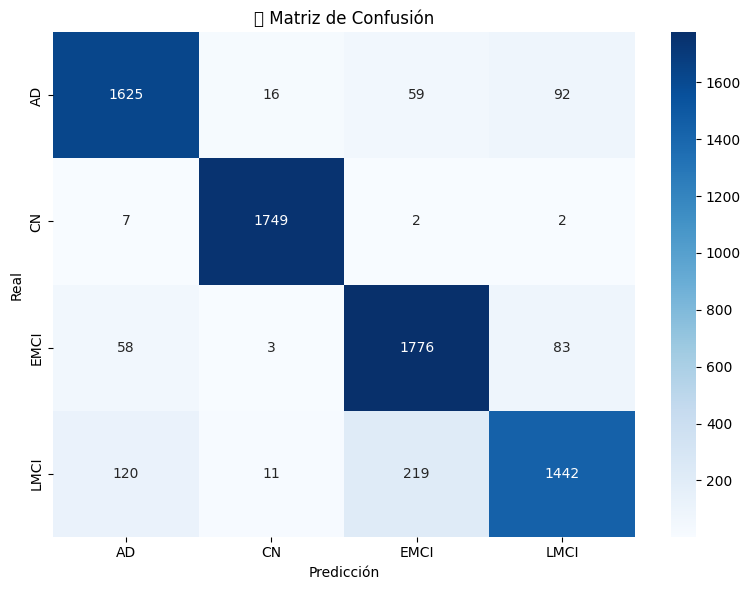

In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

model = load_model("/content/alzheimerCNN1ConModulosResiduales.keras")

start_time = time.time()

# Obtener predicciones
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Evaluación básica del modelo
loss, acc = model.evaluate(test_gen, verbose=0)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n📊 Pérdida: {loss:.4f} | Precisión (accuracy): {acc:.4f}")
print(f"🎯 Precisión: {precision:.4f} | 🔁 Recall: {recall:.4f} | ⚖️ F1-score: {f1:.4f}")
print(f"\n📦 Total de parámetros del modelo: {model.count_params()}")
print(f"⏱️ Tiempo de evaluación: {time.time() - start_time:.2f} segundos")

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("🧠 Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


Curvas de entrenamiento

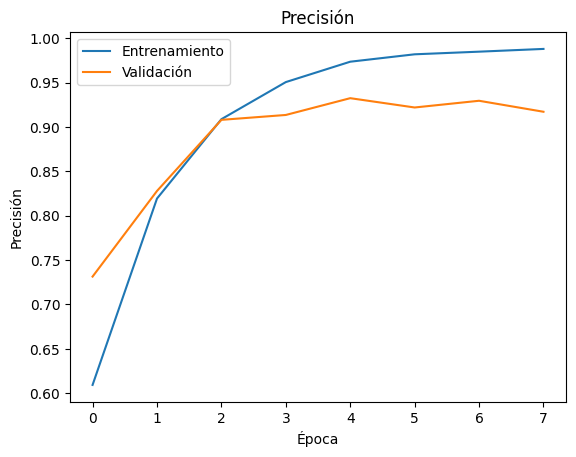

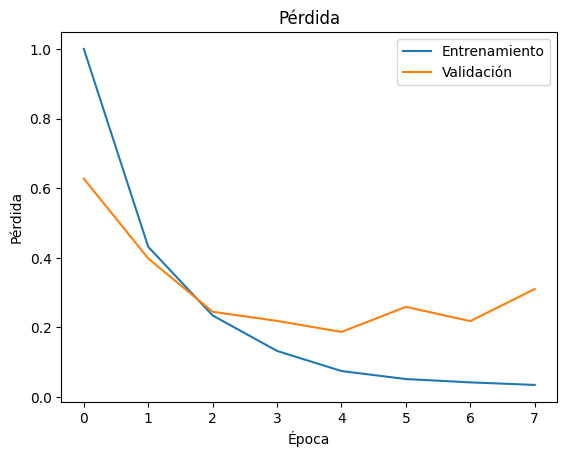

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Visualización de kernels

Visualizando capa: conv2d


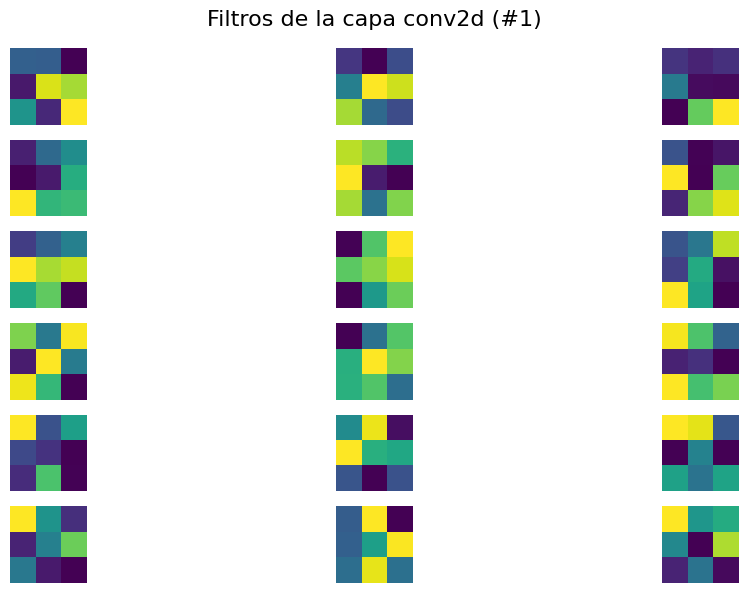

Visualizando capa: conv2d_1


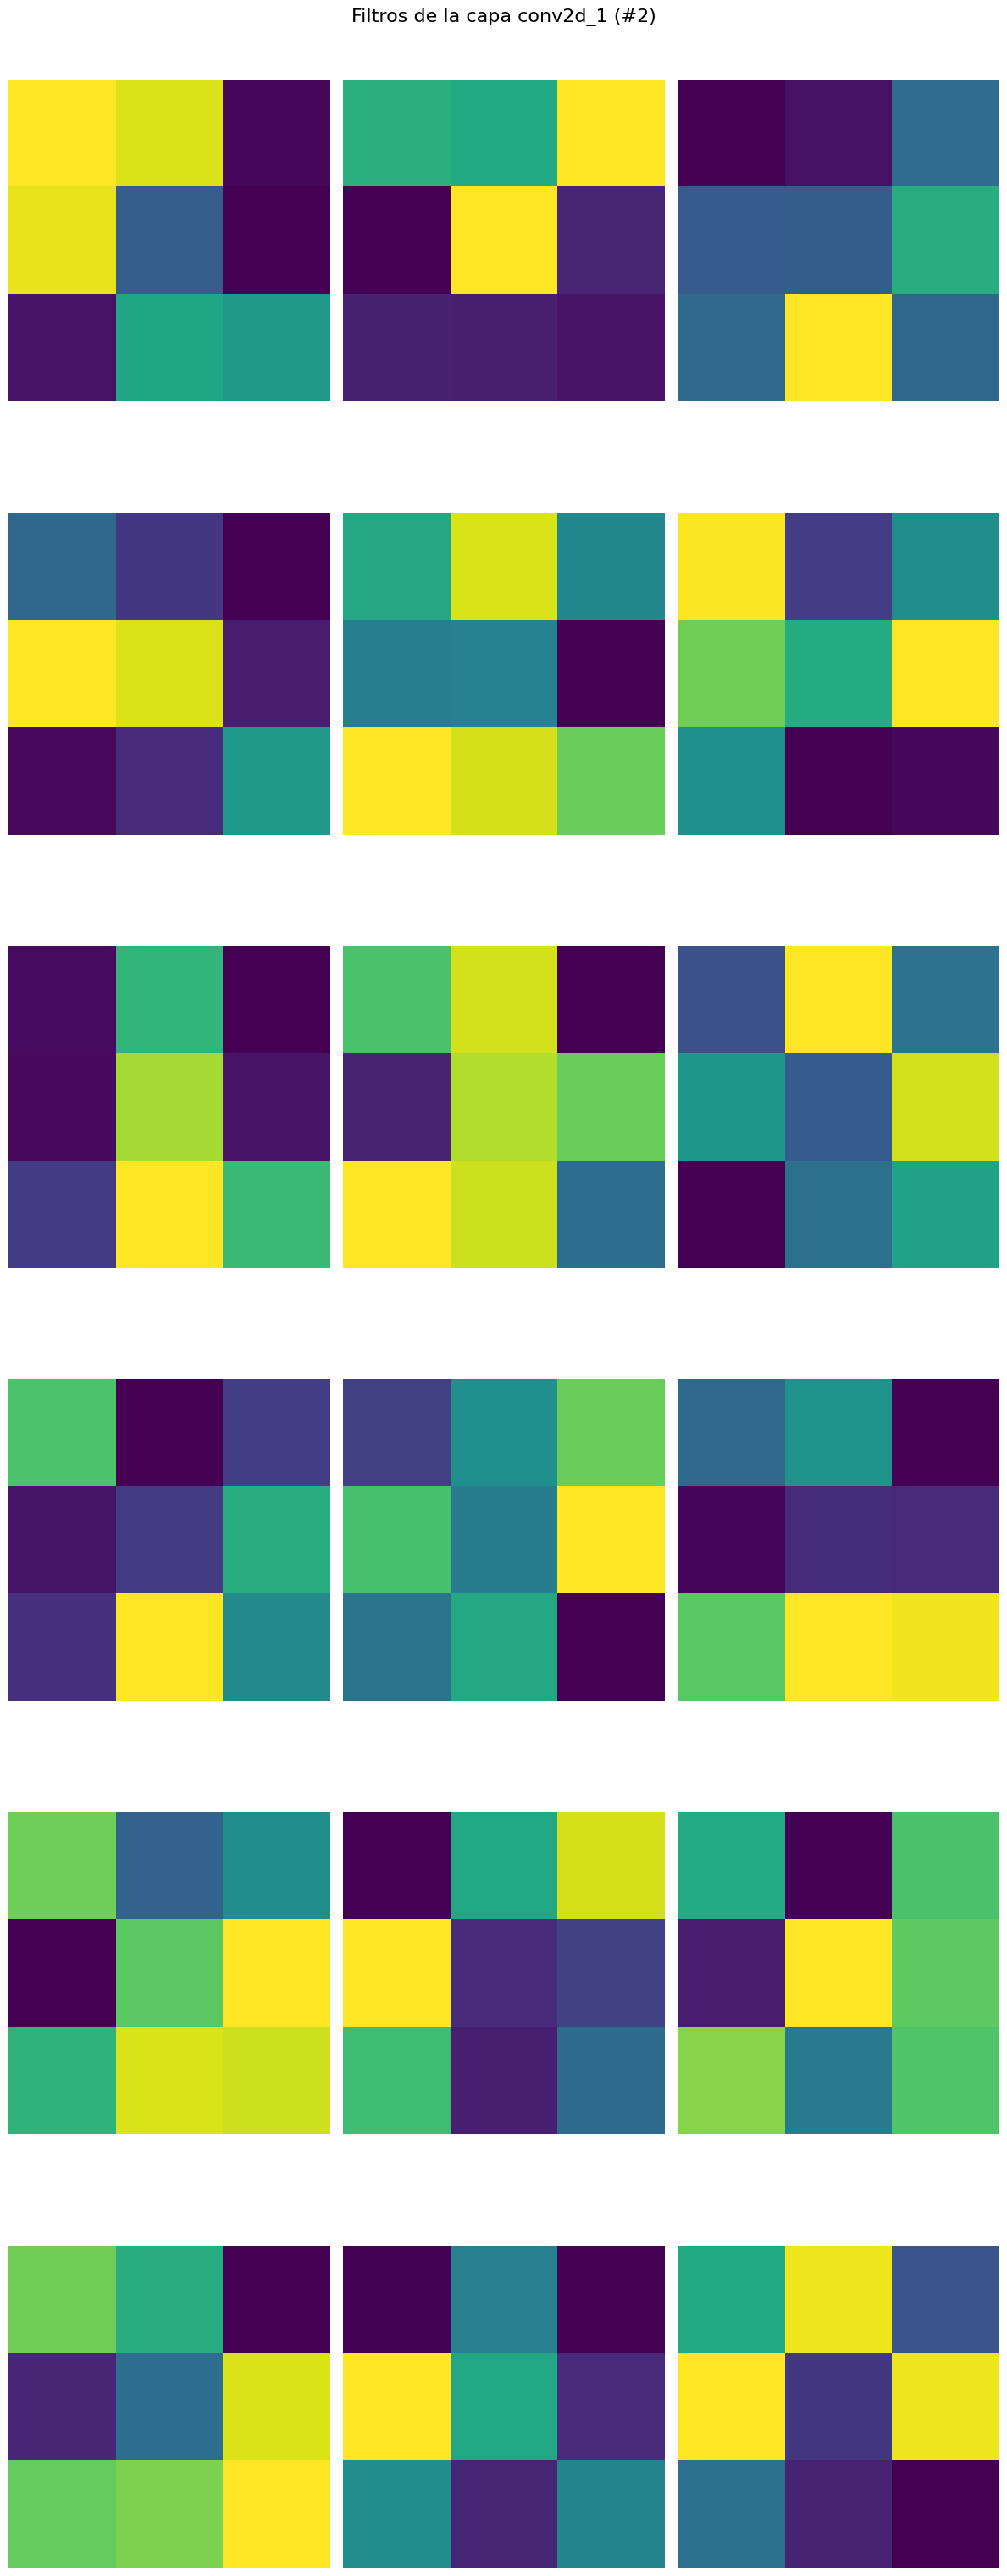

Visualizando capa: conv2d_2


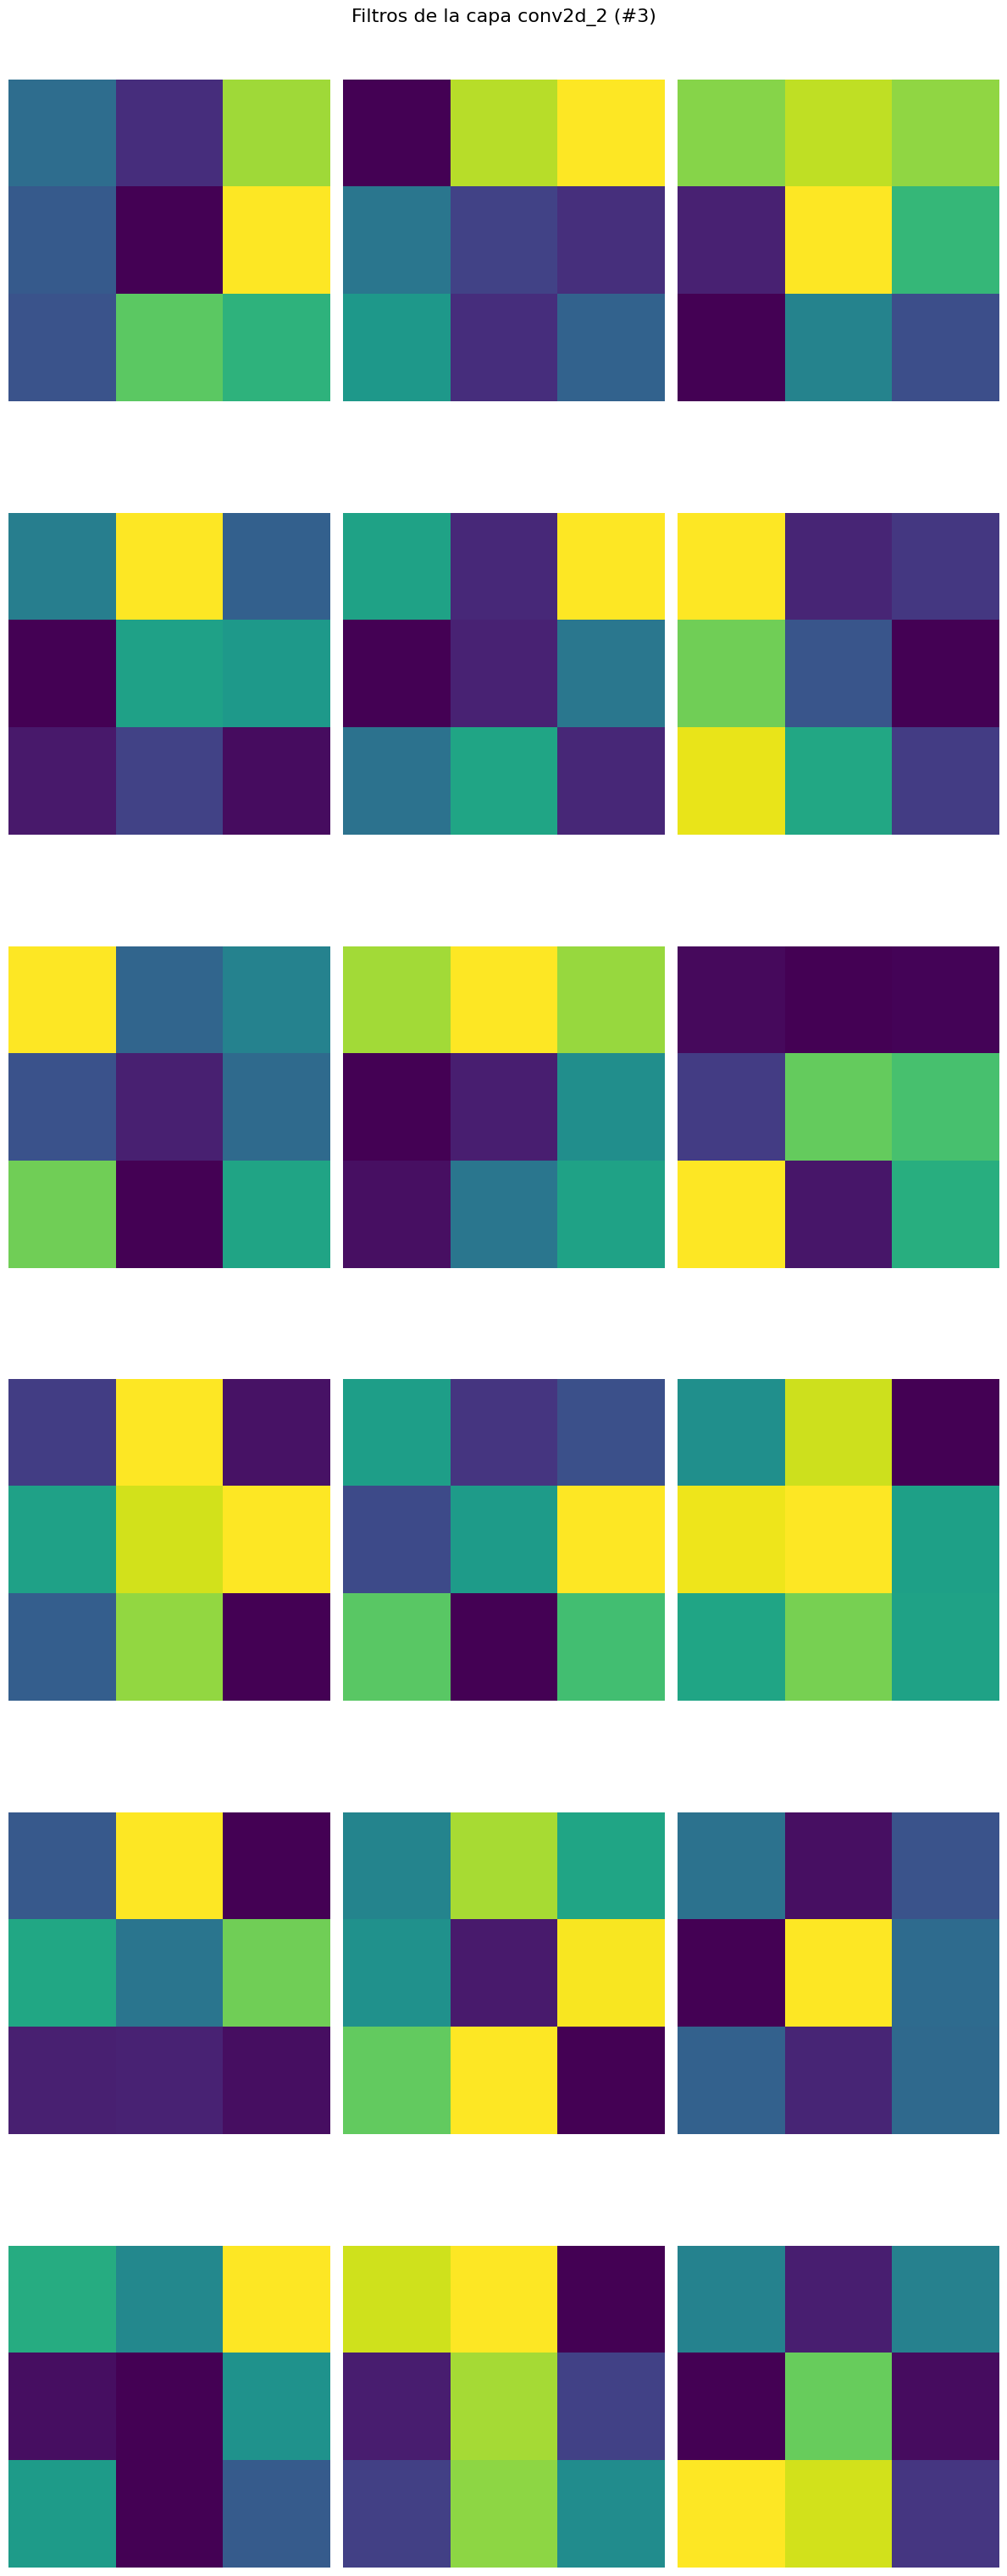

Visualizando capa: conv2d_3


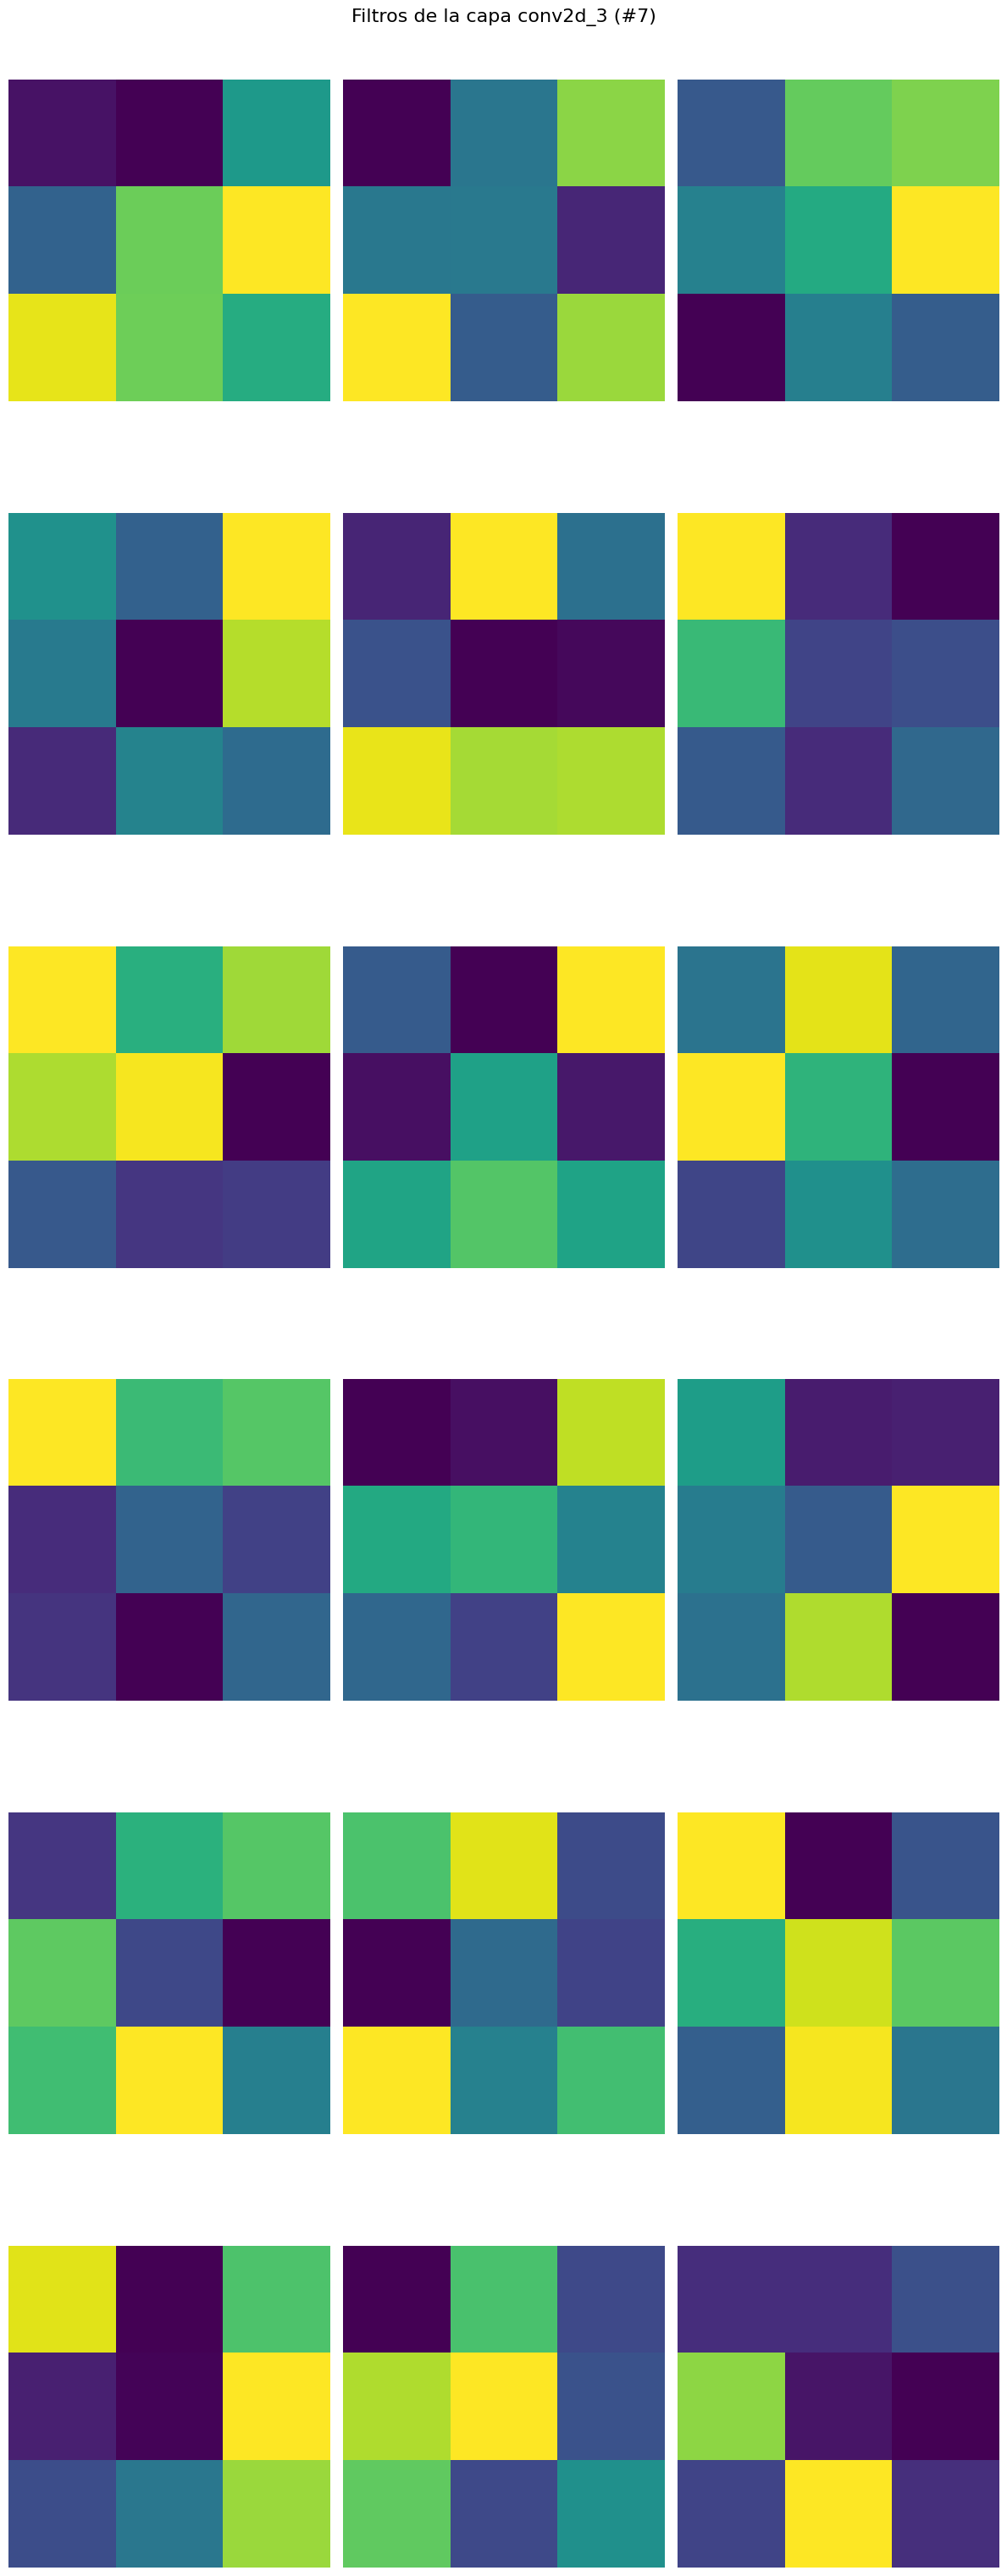

Visualizando capa: conv2d_4


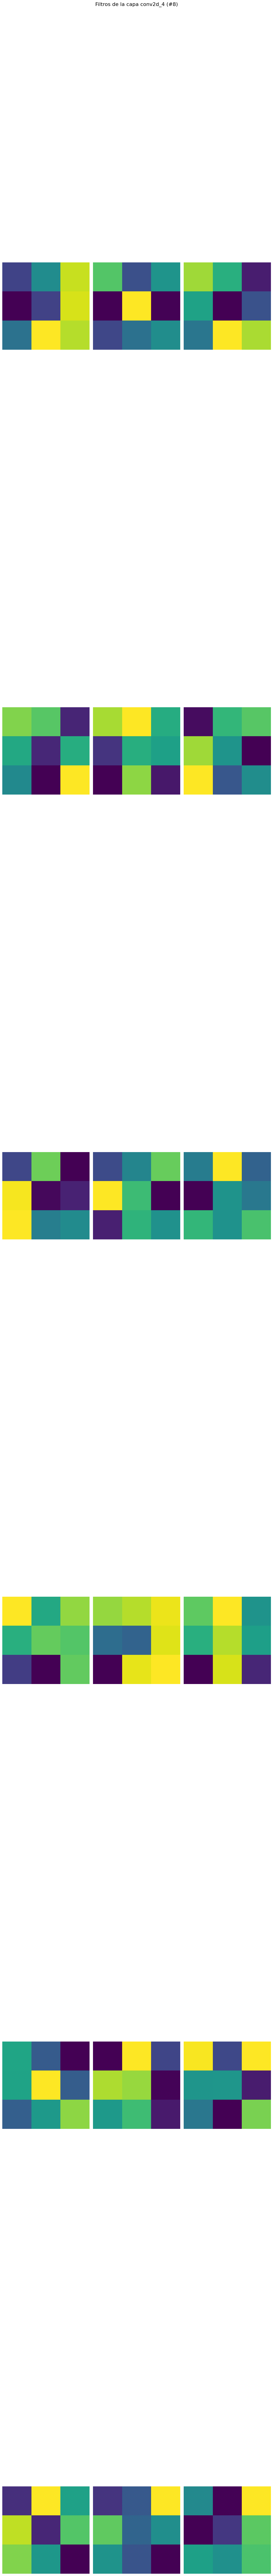

Visualizando capa: conv2d_5


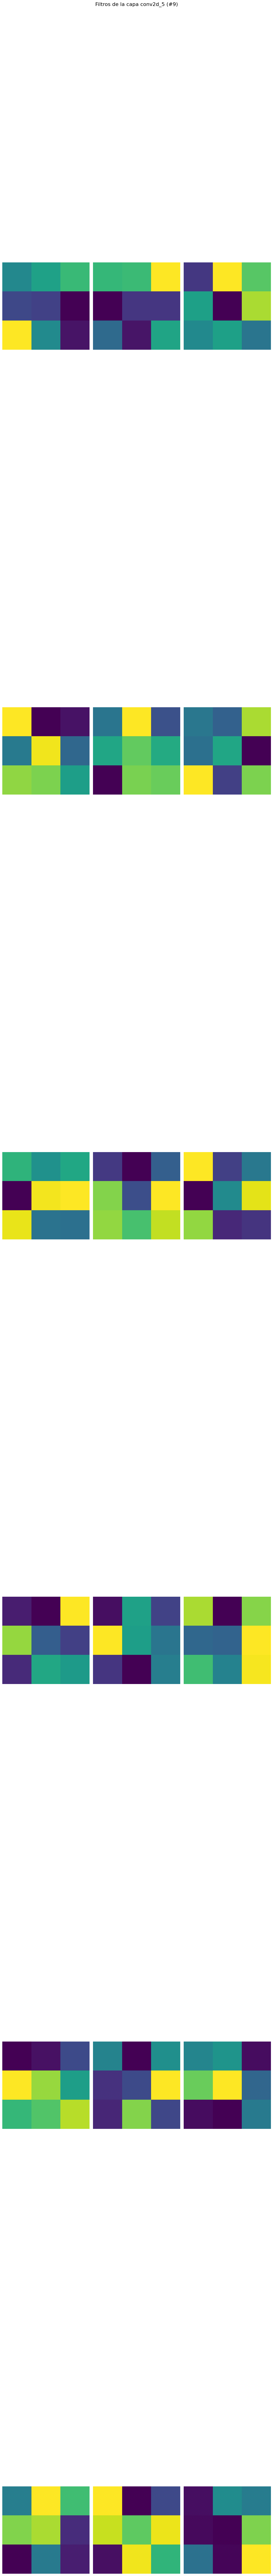

Visualizando capa: conv2d_6


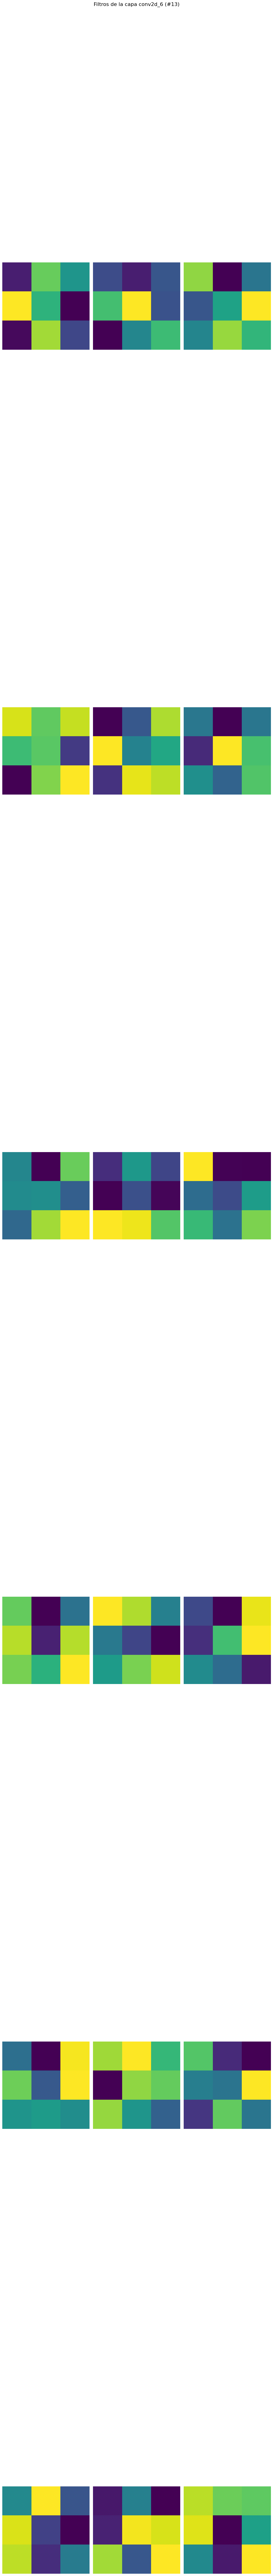

Visualizando capa: conv2d_7


Visualizando capa: conv2d_8


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Número de filtros a mostrar por capa
n_filters = 6

# Función para visualizar filtros de una capa
def visualizar_filtros(layer, layer_index):
    filters, biases = layer.get_weights()

    # Normalizar filtros para visualización
    filters_min = filters.min()
    filters_max = filters.max()
    filters_norm = (filters - filters_min) / (filters_max - filters_min)

    num_channels = filters.shape[2]  # canales de entrada
    num_filters = min(n_filters, filters.shape[3])

    plt.figure(figsize=(num_filters * 2, num_channels * 2))
    for i in range(num_filters):
        for j in range(min(num_channels, 3)):  # Solo mostrar hasta 3 canales
            ax = plt.subplot(num_filters, min(num_channels, 3), i * min(num_channels, 3) + j + 1)
            plt.imshow(filters_norm[:, :, j, i], cmap='viridis')
            plt.axis('off')
    plt.suptitle(f"Filtros de la capa {layer.name} (#{layer_index})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Recorrer las capas convolucionales y visualizarlas
for idx, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(f"Visualizando capa: {layer.name}")
        visualizar_filtros(layer, idx)